In [1]:
import pandas as pd
import tensorflow as tf
import scipy as sc
from scipy.spatial import distance
import cv2
import numpy as np
import os
import json
from base64 import b64encode
from typing import (
    Any,
    List,
    Tuple,
)

import align.detect_face    # type: ignore
import facenet              # type: ignore

import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
base_path = "D:/NNA/"
data_path = base_path + "data/"
facenet_path = base_path + "node-facenet/"

In [3]:
class MtcnnBridge():
    """
    MTCNN Face Alignment
    """
    def __init__(self) -> None:
        self.graph = self.session = None            # type: Any
        self.pnet = self.rnet = self.onet = None    # type: Any

        self.minsize = 20                   # minimum size of face
        self.threshold = [0.6, 0.7, 0.7]    # three steps's threshold
        self.factor = 0.709                 # scale factor

    def init(self) -> None:
        """ doc """
        self.graph = tf.Graph()
        self.session = tf.Session(graph=self.graph)

        # pylint: disable=not-context-manager
        with self.graph.as_default():
            with self.session.as_default():
                self.pnet, self.rnet, self.onet = \
                    align.detect_face.create_mtcnn(self.session, None)

    def align(
            self,
            image: np.ndarray,
    ) -> Tuple[List[Any], List[Any]]:
        """ doc """
        

        bounding_boxes, landmarks = align.detect_face.detect_face(
            image,   # get rid of alpha channel(if any)
            self.minsize,
            self.pnet,
            self.rnet,
            self.onet,
            self.threshold,
            self.factor,
        )

        return bounding_boxes.tolist(), landmarks.tolist()

In [4]:
class FacenetBridge(object):
    """
    Bridge of Facenet
    """
    FACENET_MODEL = None   # type: str

    def __init__(self) -> None:
        self.graph = self.session = None        # type: Any

        self.placeholder_input = None           # type: Any
        self.placeholder_phase_train = None     # type: Any
        self.placeholder_embeddings = None      # type: Any

        self.FACENET_MODEL = FacenetBridge.get_model_path()

    def init(self) -> None:
        """ doc """
        self.graph = tf.Graph()
        self.session = tf.Session(graph=self.graph)

        # pylint: disable=not-context-manager
        with self.graph.as_default():
            with self.session.as_default():
                model_dir = os.path.expanduser(self.FACENET_MODEL)
                meta_file, ckpt_file = facenet.get_model_filenames(model_dir)
                saver = tf.train.import_meta_graph(
                    os.path.join(model_dir, meta_file),
                )
                saver.restore(
                    tf.get_default_session(),
                    os.path.join(model_dir, ckpt_file),
                )
                # facenet.load_model(self.FACENET_MODEL)

        self.placeholder_input = self.graph.get_tensor_by_name('input:0')
        self.placeholder_phase_train = \
            self.graph.get_tensor_by_name('phase_train:0')
        self.placeholder_embeddings = \
            self.graph.get_tensor_by_name('embeddings:0')

    @staticmethod
    def get_model_path() -> str:
        """
        Get facenet model path from package.json
        """
        try:
            model_path = os.environ['FACENET_MODEL']    # type: str
            return model_path
        except KeyError:
            pass

        
        module_root = facenet_path

        package = os.path.join(module_root, 'package.json')
        with open(package) as data:
            package_json = json.load(data)

        python_facenet_model_path = \
            package_json['facenet']['env']['PYTHON_FACENET_MODEL_PATH']
        model_path = os.path.join(module_root, python_facenet_model_path)

        if not os.path.exists(model_path):
            raise FileNotFoundError(
                errno.ENOENT,
                os.strerror(errno.ENOENT),
                model_path
            )

        return model_path

    def embedding(
            self,
            image: np.ndarray
    ) -> List[float]:
        """
        Get embedding
        """
        #image = base64_to_image(image_base64, row, col, depth)

        if image.ndim == 2:
            image = facenet.to_rgb(image)

        # get rid of Alpha Channel from PNG(if any) and prewhiten
        image = facenet.prewhiten(image[:, :, 0:3])

        feed_dict = {
            self.placeholder_input:         image[np.newaxis, :],
            self.placeholder_phase_train:   False,
        }
        # Use the facenet model to calcualte embeddings
        embeddings = self.session.run(
            self.placeholder_embeddings,
            feed_dict=feed_dict,
        )

        # Return the only row
        return embeddings[0].tolist()

In [5]:
def initNN():
    mtcnn = MtcnnBridge()
    mtcnn.init()


    face = FacenetBridge()
    face.init()
    print("Start!!!")
    return mtcnn, face
    
mtcnn, face = initNN()

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from D:/NNA/node-facenet/models/model-20170512-110547.ckpt-250000
Start!!!


In [6]:
def buildEmployeesEmb():
    showFullImage = True
    showResizedImage = False

        
    CSV_COLUMN_NAMES = ['numb', 'first_name', 'last_name', 'file_name']
    emp_list = pd.read_csv(data_path + "emp.csv", names=CSV_COLUMN_NAMES, header=0)
    emp_list = emp_list.head(3)

    records = []
    for emp in emp_list.values:

        rec = {
            "name": emp[1] + " " + emp[2],
            "first_name": emp[1],
            "last_name": emp[2],
            "file_name": emp[3],
            "lvl": 0,
            "embedding": []
        }

        if emp[3] == "noPhoto.png":
            continue

        image_path = data_path + "images/" + emp[3]
        image = pl.imread(fname=image_path)
        res = mtcnn.align(image)    

        pos = res[0][0]
        x = int(pos[0])
        y = int(pos[1])
        w = int(pos[2])
        h = int(pos[3])

        img = image[y:h, x:w, 0:3]

        print(rec["name"])

        if showFullImage:        
            pl.figure()
            pl.imshow(image)
            currentAxis = pl.gca()
            currentAxis.add_patch(pl.Rectangle((x, y), w - x, h - y, ec='r', fc='none'))
            pl.show()

        img = cv2.resize(img, dsize=(160, 160), interpolation=cv2.INTER_CUBIC)
        emb = face.embedding(img)

        rec["embedding"] = emb

        records.append(rec)

        if showResizedImage:
            print(rec["name"])
            pl.figure()
            pl.imshow(img)
            pl.show()

    with open(data_path + 'data.json', 'w+') as outfile:
        json.dump(records, outfile)

    print("Ready!!!")


In [7]:
dataFile = "./data.json"

def loadModel():
    file = open(dataFile, "r")
    return json.loads(file.read())

users = loadModel()

In [8]:
distances = []

def distance2(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        #sc.spatial.e
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric 
        

        return dist

In [9]:
def trackSessions(emb):

    for user in users:
        userEmb = user['embedding']        
        userName = user['name']
        
        #print(userEmb.shape)
        #print("\n")
        #print(emb.shape)
        dist = distance.euclidean(userEmb, emb)
        if dist < 1.0:            
            print(userName)
            distances.append(dist)
        #else: 
            #print("Unknown face")
        

In [10]:
def capture():
    showFullImage = True
    
    trackWebCam = False
    
    if trackWebCam:
        vcap = cv2.VideoCapture(0)
    else:
        vcap = cv2.VideoCapture("rtsp://guest:sup3rGu3st@@10.10.101.156/ch1_1.h264")
    
    #vcap.set(cv2.CV_CAP_PROP_FPS, 5)
    
    print("Capture stream")
    
    step = 100
    #while(step>0):
        
    while True:
        vcap.grab()
        vcap.grab()
        vcap.grab()
        vcap.grab()
            
        ret, image = vcap.retrieve()
        #print(ret)
        #print(image)
        
        if ret == False:
            print('Skip frame')
            return
            
        #print(image.shape)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = image[700:1000, :, :]
        
        #image = cv2.resize(image, dsize=(1200, 800), interpolation=cv2.INTER_CUBIC)
        res = mtcnn.align(image)    

        #if len(res[0]) == 0:
        pl.figure()
        pl.imshow(image)
        #pl.show()

        for pos in res[0]:
            #print (pos)

            x = int(pos[0])
            y = int(pos[1])
            w = int(pos[2])
            h = int(pos[3])

            img = image[max(y, 0):h, max(x, 0):w, 0:3]
            img = cv2.resize(img, dsize=(160, 160), interpolation=cv2.INTER_CUBIC)
            emb = face.embedding(img)

            currentAxis = pl.gca()
            currentAxis.add_patch(pl.Rectangle((x, y), w - x, h - y, ec='r', fc='none'))

            #pl.figure()
            #pl.imshow(img)
            #pl.show()

            trackSessions(emb)
            
            #pl.figure()
            #pl.imshow(frame)
            #pl.show()

            step = step - 1

        #if len(res[0]) > 0:
        pl.show()


Capture stream


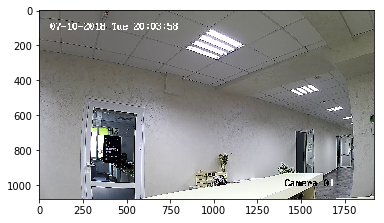

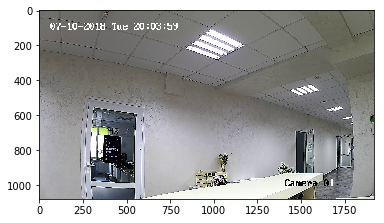

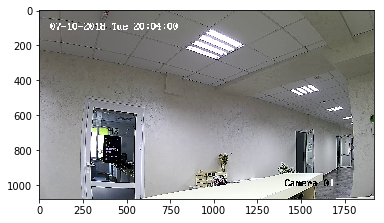

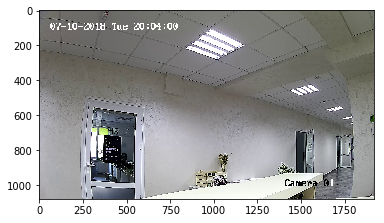

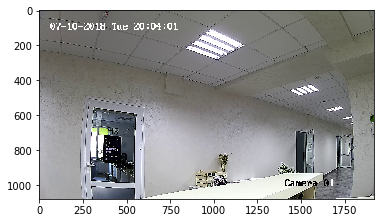

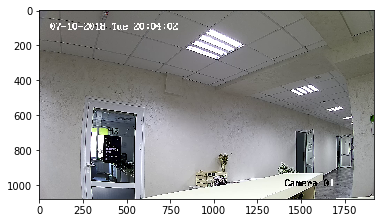

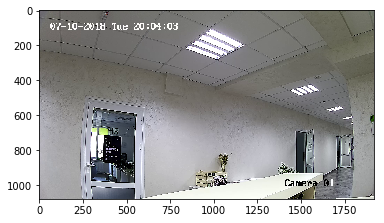

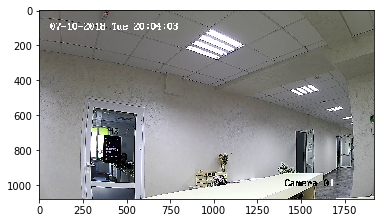

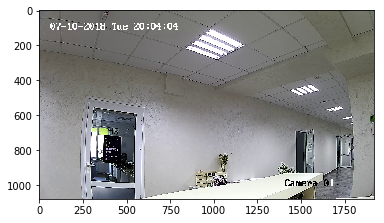

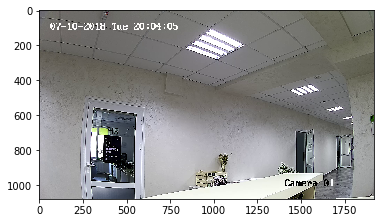

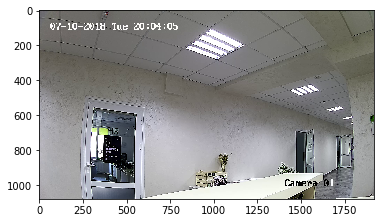

Skip frame
Capture stream


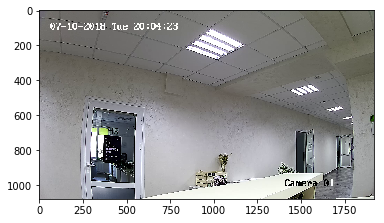

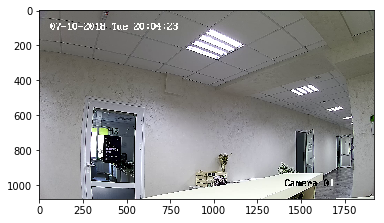

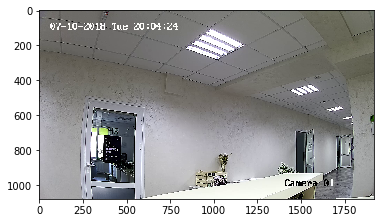

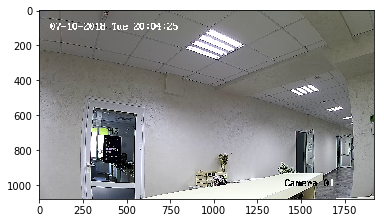

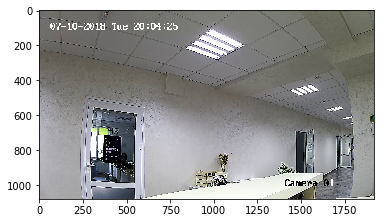

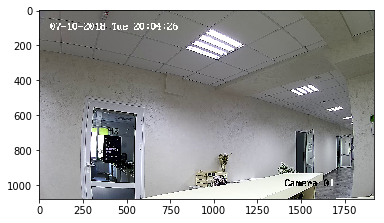

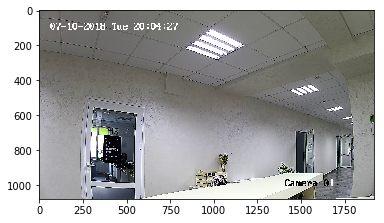

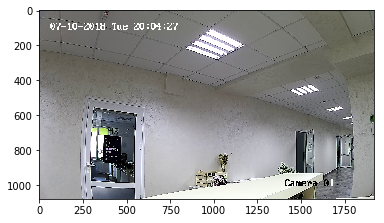

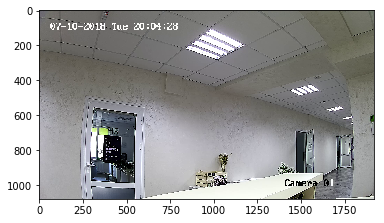

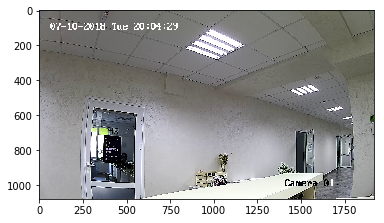

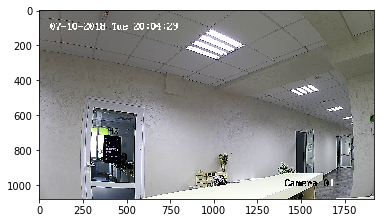

Skip frame
Capture stream


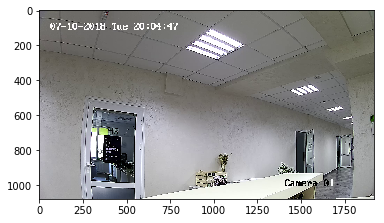

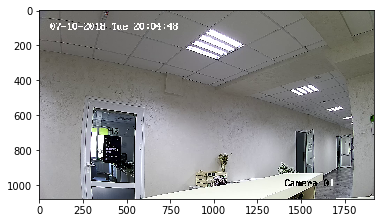

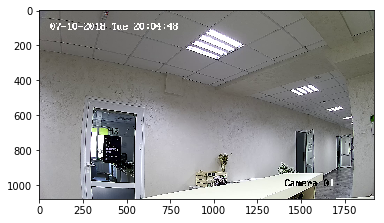

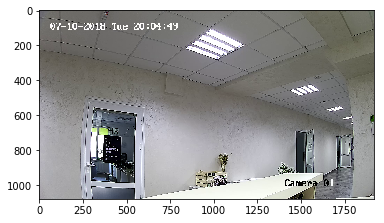

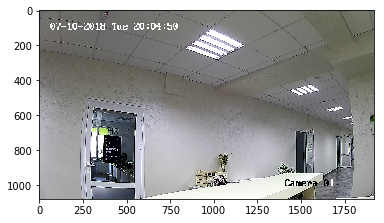

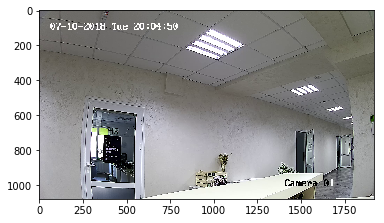

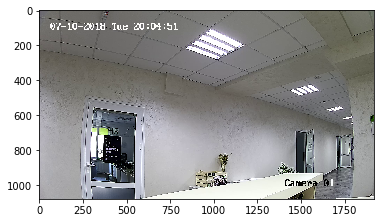

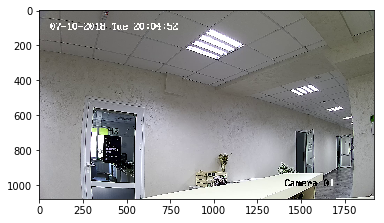

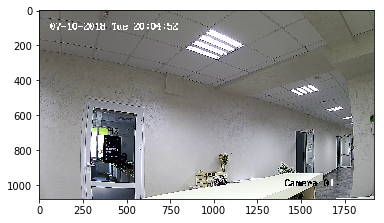

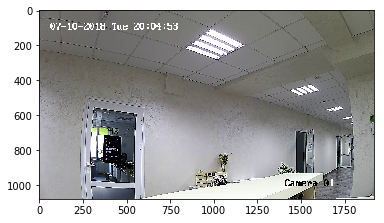

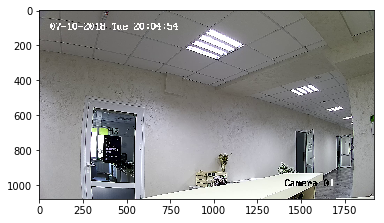

Skip frame
Capture stream


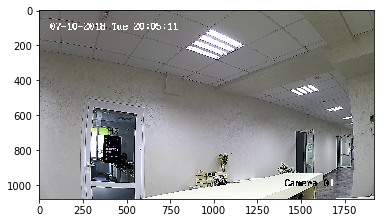

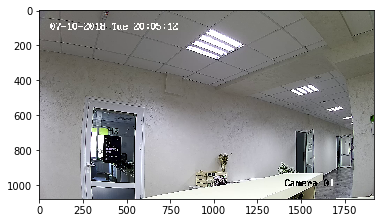

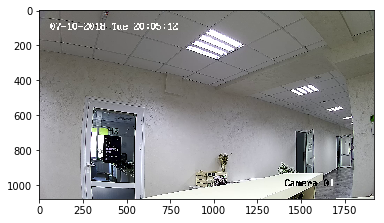

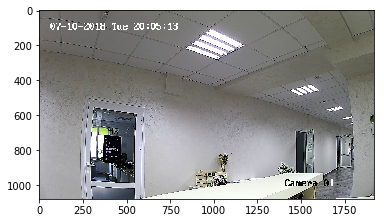

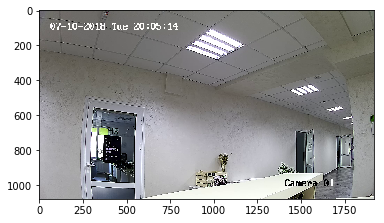

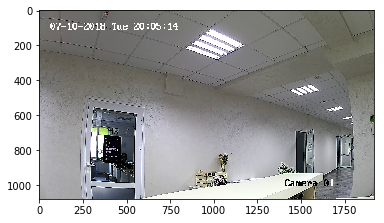

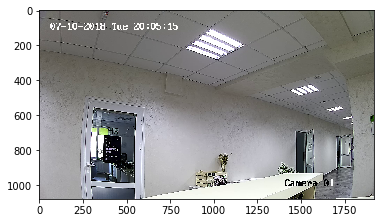

KeyboardInterrupt: 

In [11]:
while True:
    capture()